In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

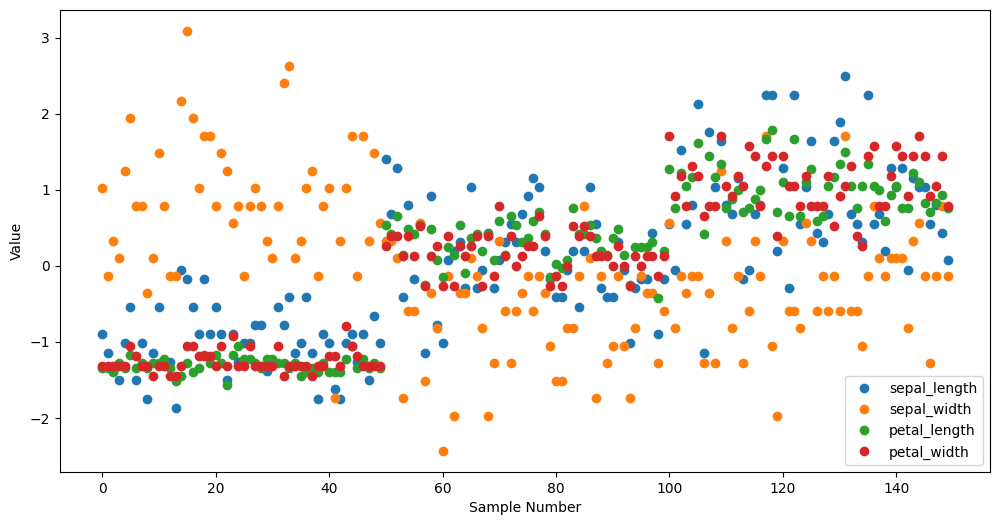

In [5]:
# import dataset from seaborn
import seaborn as sns
iris = sns.load_dataset("iris")

import scipy.stats as stats
cols2zscore = iris.keys()
cols2zscore = cols2zscore.drop("species")
iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# plot the data
iris.plot(marker = "o", linestyle = "none", figsize = (12, 6))
plt.xlabel("Sample Number")
plt.ylabel("Value")
plt.show()

In [6]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype = torch.long)
# labels[iris.species == "setosa"] = 0 # don't need
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally translate into dataloader objects
batchsize = 4
train_loader = DataLoader(train_data, shuffle = True, batch_size = batchsize, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0]) # this is not split up and batch size = 1

In [8]:
# check sizes of data batches
for X, y in train_loader:
    print(X.shape, y.shape)

# go back and set drop_last = True in training DataLoader

torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) t

In [9]:
def createANewModel():
    # model Architecture
    ANNiris = nn.Sequential(
        nn.Linear(4, 64), # input layer
        nn.ReLU(), # activation unit
        nn.Linear(64, 64), # activation unit
        nn.ReLU(), # activation unit
        nn.Linear(64, 3) # output unit
    )

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = .0005)

    return ANNiris, lossfun, optimizer

In [10]:
# train the model

# training parameter
numepochs = 500

def trainTheModel():
    trainAcc = []
    testAcc = []
    losses = []
    
    # train the model
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())
            batchLoss.append(loss.item())
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        predlabels = torch.argmax(ANNiris(X), axis = 1)
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())
        
    # function output
    return trainAcc, testAcc, losses

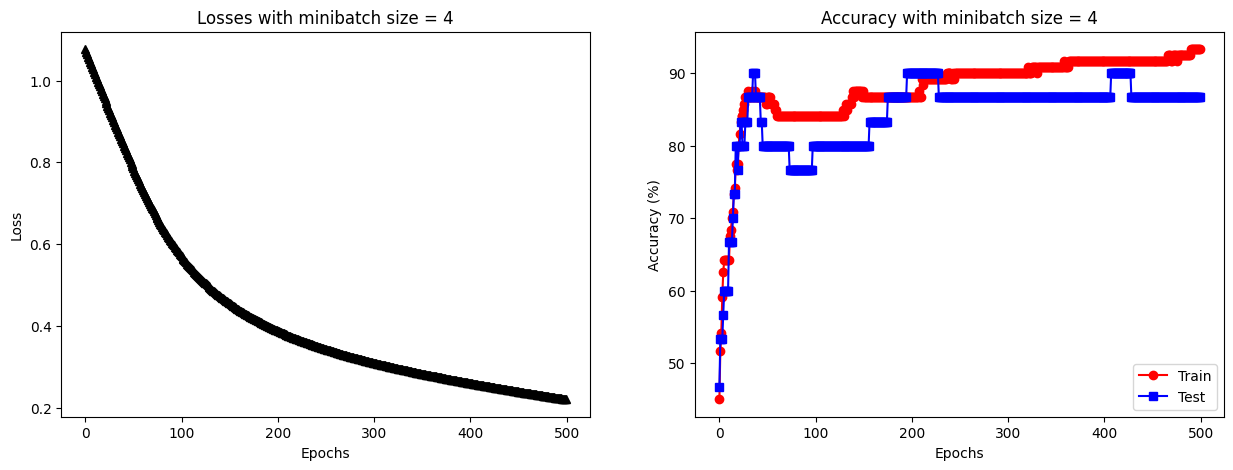

In [11]:
# create a model
ANNiris, lossfun, optimizer = createANewModel()

# train the model
trainAcc, testAcc, losses = trainTheModel()

# plot the results
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(losses, "k^-")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_title("Losses with minibatch size = " + str(batchsize))

ax[1].plot(trainAcc, "ro-")
ax[1].plot(testAcc, "bs-")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epochs")
ax[1].set_title("Accuracy with minibatch size = " + str(batchsize))
ax[1].legend(["Train", "Test"])

plt.show()